<a href="https://colab.research.google.com/github/lizhieffe/llm_knowledge/blob/main/kaggle/neurips_2025_google_code_golf_championship/Eval_with_vLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab is for the championship: https://www.kaggle.com/competitions/google-code-golf-2025/overview

Note
- The Ollama Eval colab: https://github.com/lizhieffe/llm_knowledge/blob/main/kaggle/neurips_2025_google_code_golf_championship/Eval_with_Ollama.ipynb

# TLDR

## Model Quality Comparison

The 400 data points eval results are used to measure the quality.

> Note: most of the model names are for Ollama; you can map to the equivalent vLLM (HF) model names yourself.

| Model | Valid Code Rate | Correct Code Rate |
| :--- | :--- | :--- |
| **W3S** | 0.78 | 0.06 |
| **W3M** | 0.47 | 0.04 |
| **qwen2.5-coder:0.5b** | 0.04 | 0.00 |
| **qwen2.5-coder:1.5b** | 0.15 | 0.00 |
| **qwen2.5-coder:7b** | 0.34 | 0.01 |
| **qwen2.5-coder:14b** | 0.39 | 0.03 |
| **qwen3-coder:30b** | 0.61 | 0.11 |
| **deepseek-coder:1.3b** | 0.00 | 0.00 |
| **deepseek-coder:6.7b** | 0.19 | 0.01 |
| **deepseek-coder:33b** | 0.20 | 0.05 |
| **cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit** (FP8 KV quant) | 0.51 | 0.07 |

## Model Feasibility Comparison

| Model | `max_model_len` | `kv_cache_dtype` | GPU | Result |
| :--- | :--- | :--- | :--- | :--- |
| **Qwen/Qwen3-4B** | `default` | `default` | L4 | ✅ Works |
| | `default` | `default` | A100 | ✅ Works |
| **Qwen/Qwen3-8B** | `default` | `default` | L4 | ❌ Doesn't Work |
| | `default` | `default` | A100 | ✅ Works |
| | `4096` | `default` | L4 | ✅ Works |
| **Qwen/Qwen3-14B** | `default` | `default` | L4 | ❌ Doesn't Work |
| | `default` | `default` | A100 | ✅ Works |
| | `2048` | `default` | L4 | ❌ Doesn't Work |
| **Qwen/Qwen3-32B** | `3072` | `default` | A100 | ❌ Doesn't Work |
| **Qwen3-Coder-30B-FP8** | `3072` | `default` | A100 | ✅ Works |
| | `4096` | `default` | A100 | ❌ Doesn't Work |
| **Qwen3-Coder-30B-AWQ** | `4K` | `default` | L4 | ✅ Works |
| | `5K` | `default` | L4 | ❌ Doesn't Work |
| | `12K` | `fp8` | L4 | ✅ Works |
| | `16K` | `fp8` | L4 | ❌ Doesn't Work |

## Performance

| `MODEL_NAME` | `GPU` | `Engine` | `MAX_MODEL_LEN` | `kv_cache_dtype` | Speed | Throughput |
| :--- | :--- | :--- | :--- | :--- | :--- |  :--- |
| `cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit` | L4 | vLLM | `8192` | `fp8` | `7s/it` | `200 toks/s` |
| `Qwen/Qwen3-32B` | L4 | `Ollama` | `default` | `N/A` | `43s/it` | `?` |
| `cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit` | A100 | vLLM | `8192` | `fp8` | `15s/it` | `122 toks/s` |



# Public Interface

In [1]:
import dataclasses
import numpy as np


@dataclasses.dataclass
class DataPoint:
  # A list of (input, output) tuples
  train: list[tuple[np.ndarray, np.ndarray]]
  train_raw: list[dict]

  # (input, output) tuple
  test: list[tuple[np.ndarray, np.ndarray]]
  test_raw: list[dict]

# Download data and load

In [2]:
# @title Setup Kaggle credential

# Option 1 - Load kaggle secret from the Colab's Secrets
#
# This requires to save the download kaggle secrect json file's content to the colab's Secrets with name "kaggle"
import os
from google.colab import userdata
kaggle_secret_json = userdata.get('kaggle')
os.environ['env_var_kaggle_secret_json'] = kaggle_secret_json

!mkdir -p ~/.kaggle/ && > ~/.kaggle/kaggle.json && echo $env_var_kaggle_secret_json >> ~/.kaggle/kaggle.json && chmod 600 ~/.kaggle/kaggle.json

# Option 2 - Upload kaggle secret from local file
#
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [3]:
# @title Download data

%%capture


import os


base_path = "/content/google-code-golf-2025"

if not os.path.isdir(base_path):
  !pip install --user kaggle
  !kaggle competitions download -c google-code-golf-2025
  !unzip /content/google-code-golf-2025.zip -d /content/google-code-golf-2025/

In [4]:
# @title Parse the data

import json
import os

import numpy as np

print(f"Attempting to list files in: {base_path}")

# This returns a list of filename strings. It doesn't include the path.
files = os.listdir(base_path)
json_file_paths = [
    os.path.join(base_path, f) for f in files if f.endswith(".json")
]
print(f"Found {len(json_file_paths)} json files")

def extract_data_point(json_filepath: str) -> DataPoint:
  """Extract DataPoint from a json file.

  Args:
    json_filepath: The path to the json file.

  Returns:
    A DataPoint object.Ï
  """
  with open(json_filepath, "rt") as my_file:
    content = my_file.read()
    # print(content)
    json_dict = json.loads(content)
    # print(type(json_dict))

    train_val = json_dict["train"]
    all_train = [
        (np.array(it["input"]), np.array(it["output"])) for it in train_val
    ]
    train_raw = train_val

    test_val = json_dict["train"]
    all_test = [
        (np.array(it["input"]), np.array(it["output"])) for it in test_val
    ]
    test_raw = test_val

    return DataPoint(
        train=all_train, train_raw=train_raw, test=all_test, test_raw=test_raw
    )


import tqdm
import concurrent.futures

with concurrent.futures.ThreadPoolExecutor(
    max_workers=min(512, len(json_file_paths)), thread_name_prefix="Worker"
) as executor:
  # The map() function is the key.
  # It applies 'worker_task' to each item in 'items_to_process'.
  # It automatically collects the results and returns them as an iterator.
  data_points = list(
      tqdm.tqdm(
          executor.map(extract_data_point, json_file_paths),
          total=len(json_file_paths),
      )
  )
  print(f"{len(data_points)=}")

Attempting to list files in: /content/google-code-golf-2025
Found 400 json files


100%|██████████| 400/400 [00:00<00:00, 321957.70it/s]

len(data_points)=400


In [5]:
# @title Install vLLM and dependencies

%%capture

# The 0.10 version of vLLM doesn't load model successfully. So we use 0.9.2 version

# Similar bugs
#   https://github.com/vllm-project/vllm/issues/17618
!pip install vllm==0.9.2 lm-format-enforcer pandas

# This is needed to be compatible with vLLM 0.9.2.
#
# For issue: https://github.com/vllm-project/vllm/issues/17618
!pip install "transformers<4.54.0"

!pip show vllm

# Generation libs

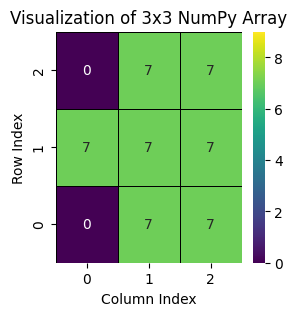

In [6]:
# @title Visualization libs

import matplotlib.pyplot as plt
import seaborn as sns # Optional, for slightly nicer colorbars and default styles

def visualize_np_array(np_array):
    """
    Visualizes a 2D NumPy array (rectangular matrix of integers between 0 and 9)
    as a heatmap.

    Args:
        np_array (np.ndarray): The NumPy array to visualize.
                               Expected shape: (rows, cols)
                               Expected values: integers between 0 and 9.
    """
    if not isinstance(np_array, np.ndarray):
        np_array = np.array(np_array)

    if np_array.ndim != 2:
        print(f"Error: Input array must be 2-dimensional, but has {np_array.ndim} dimensions.")
        return

    rows, cols = np_array.shape

    if not (1 <= rows <= 30 and 1 <= cols <= 30):
        print(f"Error: Array dimensions ({rows}x{cols}) are outside the allowed range (1x1 to 30x30).")
        return

    # Check if all values are integers between 0 and 9
    if not (np.all(np_array >= 0) and np.all(np_array <= 9) and np.all(np_array == np_array.astype(int))):
        print("Warning: Array contains values outside the 0-9 integer range. Visualization might be misleading.")
        # Attempt to cast to int to prevent issues with imshow expecting numeric data
        np_array = np_array.astype(int)

    # Set up the plot
    image_zoom_factor = 1.0 if rows <= 10 and cols <= 10 else 0.5
    plt.figure(figsize=(cols * image_zoom_factor, rows * image_zoom_factor)) # Adjust figure size dynamically for better aspect ratio

    # Use seaborn's heatmap for a more aesthetically pleasing visualization
    # 'cmap' defines the color map. 'viridis' is a good default for sequential data.
    # 'RdYlGn' (Red-Yellow-Green) or 'Greens' are also good options.
    # 'annot=True' will display the value in each cell (useful for small grids)
    # 'fmt="d"' ensures the annotation is an integer
    # 'cbar=True' shows the color bar
    # 'linewidths' and 'linecolor' add borders between cells
    sns.heatmap(np_array, annot=True, fmt="d", cmap="viridis", cbar=True,
                linewidths=0.5, linecolor='black', vmin=0, vmax=9)

    plt.title(f'Visualization of {rows}x{cols} NumPy Array')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.xticks(np.arange(cols) + 0.5, labels=np.arange(cols)) # Center ticks
    plt.yticks(np.arange(rows) + 0.5, labels=np.arange(rows)) # Center ticks
    plt.gca().invert_yaxis() # Invert y-axis to have (0,0) at top-left like typical arrays

    plt.show()

array = np.array([[0, 7, 7], [7, 7, 7], [0, 7, 7]])
visualize_np_array(array)

In [7]:
# @title Prompt Libs
SYSTEM_TURN = """You are a principle software engineer.

"""


USER_TURN_PREFIX = """You should implement a Python function to do a transformation, where the transformation is implicitly described by multiple pair of <input, output> image grids that are given. For example, the example pairs for one task might demonstrate the concept of rotation, whereas another might involve cropping and/or magnification. Your code for a given task should not only achieve the desired result across all exemplars, but also do so using the fewest possible number of characters.

A "grid" is a rectangular matrix (list of lists) of integers between 0 and 9 (inclusive). The smallest possible grid size is 1x1 and the largest is 30x30.

The function should have name "fn", one input arg named "input".

Do NOT use any external library!

Examplars:

"""


def build_prompt(data_point: DataPoint) -> list[dict[str, str]]:
  user_turn = USER_TURN_PREFIX
  user_turn += str(data_point.train_raw)

  messages = [
      {"role": "system", "content": SYSTEM_TURN},
      {"role": "user", "content": user_turn},
  ]
  return messages


# Test
conversation = build_prompt(data_points[0])
print(f"Prompt = {conversation}")

Prompt = [{'role': 'system', 'content': 'You are a principle software engineer.\n\n'}, {'role': 'user', 'content': 'You should implement a Python function to do a transformation, where the transformation is implicitly described by multiple pair of <input, output> image grids that are given. For example, the example pairs for one task might demonstrate the concept of rotation, whereas another might involve cropping and/or magnification. Your code for a given task should not only achieve the desired result across all exemplars, but also do so using the fewest possible number of characters.\n\nA "grid" is a rectangular matrix (list of lists) of integers between 0 and 9 (inclusive). The smallest possible grid size is 1x1 and the largest is 30x30.\n\nThe function should have name "fn", one input arg named "input".\n\nDo NOT use any external library!\n\nExamplars:\n\n[{\'input\': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0

In [8]:
# @title Generate Code Libs

def extract_code_from_resp(resp_str: str) -> str:
  prefix = "```python"
  suffix = "```"
  while True:
    prefix_idx = resp_str.find(prefix)
    if prefix_idx != -1:
      resp_str = resp_str[prefix_idx + len(prefix) :]
    else:
      break
  suffix_idx = resp_str.find(suffix)
  if suffix_idx != -1:
    resp_str = resp_str[: suffix_idx]
  return resp_str.strip()

In [9]:
# @title JIT Python execution libs

import typing
import numpy as np


def exec_and_ret(code_str: str, input: np.ndarray) -> typing.Any:
  """Execute a string of code and return the result.

  The result must be assigned to a variable named 'ret'.

  Args:
    code_str: A string of code.
    input: the input to the code.

  Returns:
    The result of the code.
  """
  loc = {}
  exec(code_str, {'input': input}, loc)
  return loc['ret']


# # Test
# code_str = """ret = 1 + 2"""
# assert 3 == exec_and_ret(code_str, input)

In [10]:
# @title Verification libs
!pip install func-timeout

from typing import Any
from func_timeout import func_timeout, FunctionTimedOut


def verify_code(
    code_str: str, data_point: DataPoint, visualize: bool = False, timeout_seconds:int = 30
) -> tuple[bool, list[Any], list[Any]]:
  """Verify the given code on its expected result."""

  # This is needed to emit the return of the execution.
  code_str += """
ret = fn(input)"""

  assert data_point.test
  inp = data_point.test[0][0].tolist()
  expected_output = data_point.test[0][1].tolist()

  # Execute the code with a timeout to prevent culprit code never returns.
  try:
    # The return value of successful_function is captured in 'result'
    output = func_timeout(timeout_seconds, exec_and_ret, args=(code_str, inp))

    if visualize:
      visualize_np_array(output)
      visualize_np_array(expected_output)

    is_match = np.allclose(np.array(output), np.array(expected_output))

    return is_match, output, expected_output
  except FunctionTimedOut:
    print(f"🛑 The function was killed after {timeout_seconds} seconds.\n")
    return False, None, expected_output


# # Test
# is_match, output, expected_output = verify_code(
#     """def fn(inp):
#       return 1""",
#     data_points[0],
# )
# print(is_match)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15163 sha256=276c222b82fdb8cf7b938f0a66b777e70e624036a70684d649c0a5e0426f559d
  Stored in directory: /root/.cache/pip/wheels/ed/94/4a/9ccd71f7284a92e4137b7dd0ce8540c40ea7c2689251504a49
Successfully built func-timeout


# Run evals

In [11]:
# @title Init the vLLM
import vllm
import os

# llm = vllm.LLM(model="Qwen/Qwen3-0.6B") # OK
# llm = vllm.LLM(model="Qwen/Qwen3-4B") # OK
# llm = vllm.LLM(model="Qwen/Qwen3-8B", max_model_len=4096) # OK on A100. OK on L4 after max_model_len=4096.
# llm = vllm.LLM(model="Qwen/Qwen3-14B", max_model_len=2048) # OK on A100. Not working on L4 after max_model_len=2048, 3072 or 4096
# llm = vllm.LLM(model="Qwen/Qwen3-32B", max_model_len=3072) # Not working on A100 after max_model_len=3072, 4096
# llm = vllm.LLM(model="Qwen/Qwen3-Coder-30B-A3B-Instruct-FP8", max_model_len=4096) # OK on A100 for 3072; hasn't try 4096. For L4, 4096 doesn't work.

MODEL_NAME = "cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit"
MAX_MODEL_LEN = 1024 * 8

llm = vllm.LLM(
    model=MODEL_NAME,
    max_model_len=MAX_MODEL_LEN,
    # gpu_memory_utilization=0.95,
    kv_cache_dtype="fp8",
    ) # L4: non-fp8 OK 4096, Not OK 5120, 6144, 8192; fp8: OK 8192, 1024*12, Not OK 1024*16

INFO 08-20 22:21:17 [__init__.py:244] Automatically detected platform cuda.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

INFO 08-20 22:21:37 [config.py:841] This model supports multiple tasks: {'embed', 'classify', 'generate', 'reward'}. Defaulting to 'generate'.
INFO 08-20 22:21:37 [config.py:1472] Using max model len 8192
WARNING 08-20 22:21:37 [arg_utils.py:1735] --kv-cache-dtype is not supported by the V1 Engine. Falling back to V0. 
INFO 08-20 22:21:37 [config.py:1593] Using fp8 data type to store kv cache. It reduces the GPU memory footprint and boosts the performance. Meanwhile, it may cause accuracy drop without a proper scaling factor
INFO 08-20 22:21:37 [llm_engine.py:230] Initializing a V0 LLM engine (v0.9.2) with config: model='cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit', speculative_config=None, tokenizer='cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_para

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

INFO 08-20 22:21:42 [cuda.py:344] Cannot use FlashAttention backend for FP8 KV cache.
WARNING 08-20 22:21:42 [cuda.py:346] Please use FlashInfer backend with FP8 KV Cache for better performance by setting environment variable VLLM_ATTENTION_BACKEND=FLASHINFER
INFO 08-20 22:21:42 [cuda.py:360] Using XFormers backend.
INFO 08-20 22:21:43 [parallel_state.py:1076] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
INFO 08-20 22:21:43 [model_runner.py:1171] Starting to load model cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit...
INFO 08-20 22:21:43 [compressed_tensors_wNa16.py:95] Using MarlinLinearKernel for CompressedTensorsWNA16
WARNING 08-20 22:21:44 [config.py:440] MoE DP setup unable to determine quantization scheme or unsupported quantization type. This model will not run with DP enabled.
INFO 08-20 22:21:44 [compressed_tensors_moe.py:82] Using CompressedTensorsWNA16MarlinMoEMethod
INFO 08-20 22:21:44 [weight_utils.py:292] Using model weights format ['*.s

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.69G [00:00<?, ?B/s]

INFO 08-20 22:23:21 [weight_utils.py:308] Time spent downloading weights for cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit: 97.181512 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 08-20 22:23:44 [default_loader.py:272] Loading weights took 22.63 seconds
WARNING 08-20 22:23:44 [kv_cache.py:86] Checkpoint does not provide a q scaling factor. Setting it to k_scale. This only matters for the flash-attn backend.
WARNING 08-20 22:23:44 [kv_cache.py:99] Using KV cache scaling factor 1.0 for fp8_e4m3. This may cause accuracy issues. Please make sure k/v_scale scaling factors are available in the fp8 checkpoint.
WARNING 08-20 22:23:44 [kv_cache.py:130] Using uncalibrated q_scale 1.0 and/or prob_scale 1.0 with fp8 attention. This may cause accuracy issues. Please make sure q/prob scaling factors are available in the fp8 checkpoint.
INFO 08-20 22:23:47 [model_runner.py:1203] Model loading took 15.6878 GiB and 122.787703 seconds
WARNING 08-20 22:23:48 [fused_moe.py:690] Using default MoE config. Performance might be sub-optimal! Config file not found at /usr/local/lib/python3.12/dist-packages/vllm/model_executor/layers/fused_moe/configs/E=128,N=4096,device_name=NVIDIA_

Capturing CUDA graph shapes:   0%|          | 0/35 [00:00<?, ?it/s]

INFO 08-20 22:24:27 [model_runner.py:1671] Graph capturing finished in 35 secs, took 0.51 GiB
INFO 08-20 22:24:27 [llm_engine.py:428] init engine (profile, create kv cache, warmup model) took 39.96 seconds


In [12]:
# @title Eval Libs

import time
import traceback

def run_eval_loop():
  # Process input
  formatted_prompts_tokenized = []

  tokenizer = llm.get_tokenizer()

  input_cutoff_len = MAX_MODEL_LEN * 3 // 4
  examples_over_max_ctx_length = []

  for dp in data_points:
      messages = build_prompt(dp)
      input_ids = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, enable_thinking=True)


      if len(input_ids) > input_cutoff_len:
        # print(f"⚠️ Warning: Prompt is too long ({len(input_ids)} tokens). Truncating to {input_cutoff_len} tokens.")
        examples_over_max_ctx_length.append(input_ids)

        # Keep the most recent tokens by slicing from the end
        input_ids = input_ids[-input_cutoff_len:]

      formatted_prompts_tokenized.append(input_ids)
  print(f"There are {len(examples_over_max_ctx_length)} examples over the max context length limit {input_cutoff_len}!")

  # Inference
  sampling_params = vllm.SamplingParams(temperature=0.8, top_p=0.95, max_tokens=2048)


  tokens_prompts = [vllm.inputs.TokensPrompt(prompt_token_ids=it) for it in formatted_prompts_tokenized]

  inference_start = time.time()
  outputs = llm.generate(prompts=tokens_prompts, sampling_params=sampling_params)
  inference_end = time.time()
  inference_time = inference_end - inference_start
  print(f"Elapsed time: {inference_time:.1f} seconds")

  # Process output
  generated_codes = []
  for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    generated_code = extract_code_from_resp(generated_text)
    generated_codes.append(generated_code)

  # Eval the outputs
  eval_results = []
  for code, dp in zip(generated_codes, data_points):
    try:
      is_match, _, _ = verify_code(code, dp)
      eval_results.append((is_match, None))
    except Exception as e:
      stack_trace = traceback.extract_stack()
      err_msg = f"Error: {e}. Stack trace: {stack_trace}"
      err = ValueError(err_msg)
      eval_results.append((False, err))

  return eval_results

In [13]:

# @title Run eval

import time

inference_start = time.time()
eval_results = run_eval_loop()

is_matches = [result[0] for result in eval_results]
errors = [result[1] for result in eval_results]

num_valid_code = errors.count(None)
num_invalid_code = errors.count(not None)
num_correct_code = sum(is_matches)
num_incorrect_code = num_valid_code - num_correct_code

print(f"Evaluating **{MODEL_NAME}** ...")
print(
    f"Valid code rate = {num_valid_code / len(eval_results):.2f}"
)
print(
    f"Correct code rate ="
    f" {num_correct_code / len(eval_results):.2f}"
)
print("=" * 80)
print("=" * 80)
print("=" * 80)

There are 28 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/400 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/400 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-20 22:25:21 [scheduler.py:1834] Sequence group 166 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=1
WARNING 08-20 23:12:46 [scheduler.py:1834] Sequence group 313 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=51
Elapsed time: 5065.8 seconds
Evaluating **cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit** ...
Valid code rate = 0.53
Correct code rate = 0.08


<string>:1: SyntaxWarning: invalid decimal literal
